### Explore processed pan-cancer data

In [1]:
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import mpmp.config as cfg
import mpmp.utilities.data_utilities as du

In [2]:
# load mutation info
print('Loading gene label data...', file=sys.stderr)
genes_df = du.load_vogelstein()
sample_info_df = du.load_sample_info(verbose=True)

# this returns a tuple of dataframes, unpack it below
pancancer_data = du.load_pancancer_data(verbose=True)
(sample_freeze_df,
 mutation_df,
 copy_loss_df,
 copy_gain_df,
 mut_burden_df) = pancancer_data

Loading gene label data...
Loading sample info...
Loading pan-cancer data from cached pickle file...


In [3]:
# load expression data
rnaseq_df = du.load_expression_data(verbose=True)

# standardize columns of expression dataframe
print('Standardizing columns of expression data...', file=sys.stderr)
rnaseq_df[rnaseq_df.columns] = StandardScaler().fit_transform(rnaseq_df[rnaseq_df.columns])

print(rnaseq_df.shape)
rnaseq_df.iloc[:5, :5]

Loading gene expression data...
Standardizing columns of expression data...


(11060, 15369)


,1,100,1000,10000,10001
sample_id,,,,,
TCGA-02-0047-01,-0.144025,-0.206544,1.029891,0.643947,-0.730368
TCGA-02-0055-01,-0.124850,-0.132174,0.689587,0.153994,-0.406662
TCGA-02-2483-01,-0.133468,-0.102772,1.448180,0.668630,0.498391
TCGA-02-2485-01,-0.146976,-0.212598,4.340760,11.504372,0.240748
TCGA-02-2486-01,-0.145246,-0.146875,0.994442,0.116970,0.386085


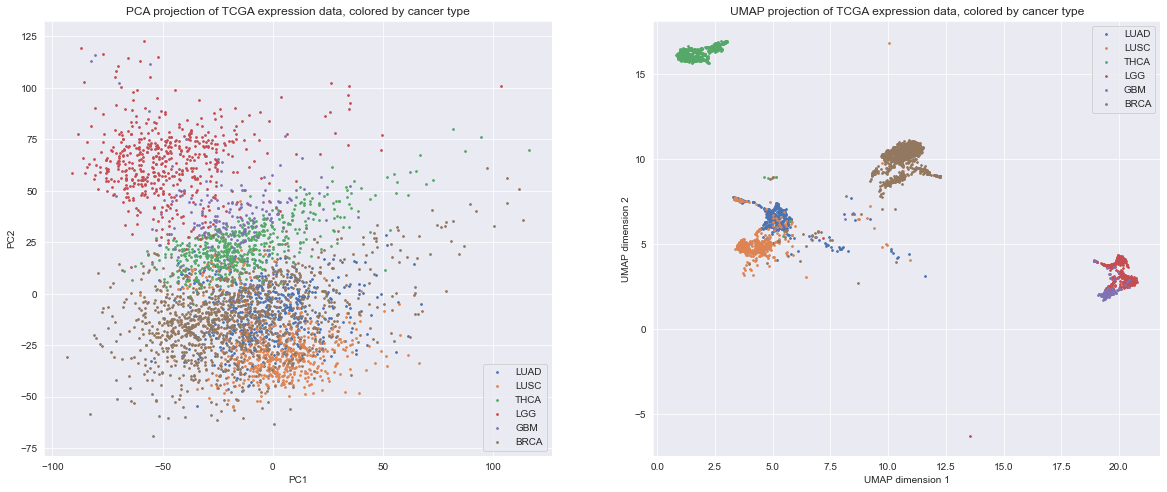

In [4]:
from sklearn.decomposition import PCA
from umap import UMAP

sns.set({'figure.figsize': (20, 8)})
fig, axarr = plt.subplots(1, 2)

assert sample_info_df.index.equals(rnaseq_df.index)

pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(rnaseq_df)
reducer = UMAP()
X_proj_umap = reducer.fit_transform(rnaseq_df)

enum_samples_df = sample_info_df.reset_index()
# rnaseq_cancer_types = sorted(sample_info_df.cancer_type.unique())
rnaseq_cancer_types = ['LUAD', 'LUSC', 'THCA', 'LGG', 'GBM', 'BRCA']
for i, cancer_type in enumerate(rnaseq_cancer_types):
    ixs = enum_samples_df.index[enum_samples_df['cancer_type'] == cancer_type].tolist()
    axarr[0].scatter(X_proj_pca[ixs, 0], X_proj_pca[ixs, 1], label=cancer_type, s=3)
    axarr[1].scatter(X_proj_umap[ixs, 0], X_proj_umap[ixs, 1], label=cancer_type, s=3)
    
axarr[0].set_xlabel('PC1')
axarr[0].set_ylabel('PC2')
axarr[0].set_title('PCA projection of TCGA expression data, colored by cancer type')
axarr[0].legend()
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].set_title('UMAP projection of TCGA expression data, colored by cancer type')
axarr[1].legend()

In [5]:
# load expression data
methylation_df = du.load_methylation_data(verbose=True)

# standardize columns of methylation dataframe
# print('Standardizing columns of methylation data...', file=sys.stderr)
# methylation_df[methylation_df.columns] = StandardScaler().fit_transform(
#     methylation_df[methylation_df.columns])

print(methylation_df.shape)
methylation_df.iloc[:5, :5]

Loading DNA methylation data...


(11985, 11882)


,cg00005847,cg00008493,cg00012199,cg00012386,cg00012792
sample_id,,,,,
TCGA-01-0628-11,0.568,0.954,0.0360,0.0215,0.0240
TCGA-01-0630-11,0.621,0.959,0.0376,0.0169,0.0283
TCGA-01-0631-11,0.431,0.963,0.0361,0.0174,0.0236
TCGA-01-0633-11,0.417,0.960,0.0387,0.0254,0.0214
TCGA-01-0636-11,0.695,0.962,0.0383,0.0191,0.0173


In [6]:
sample_overlap = rnaseq_df.index.intersection(methylation_df.index)
print(len(rnaseq_df), len(methylation_df), len(sample_overlap))

11060 11985 10587


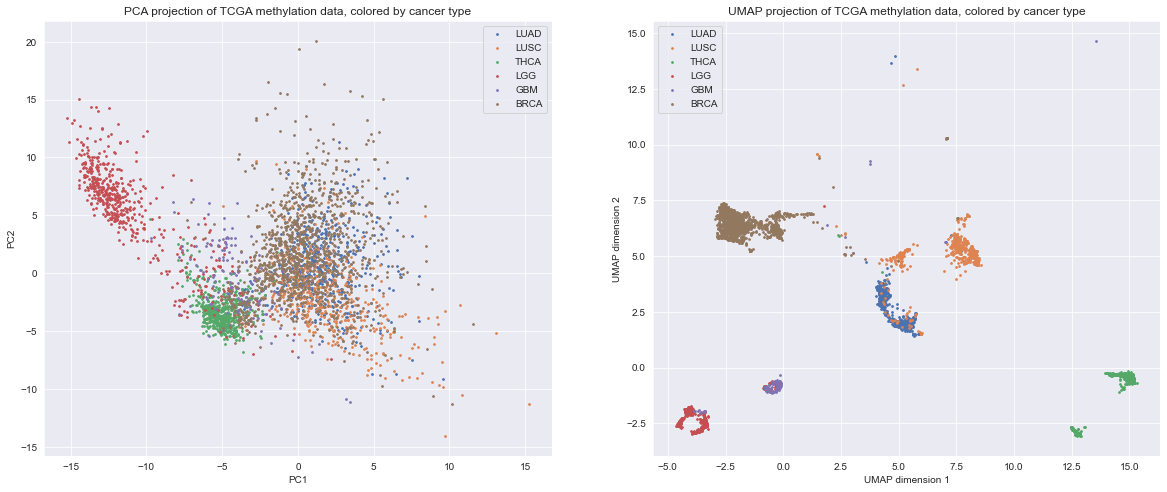

In [7]:
sns.set({'figure.figsize': (20, 8)})
fig, axarr = plt.subplots(1, 2)

methylation_filtered_df = methylation_df.reindex(sample_overlap)
enum_samples_df = (
    sample_info_df.reindex(sample_overlap)
                  .reset_index()
)

pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(methylation_filtered_df)
reducer = UMAP()
X_proj_umap = reducer.fit_transform(methylation_filtered_df)

# me_cancer_types = sorted(sample_info_df.cancer_type.unique())
me_cancer_types = ['LUAD', 'LUSC', 'THCA', 'LGG', 'GBM', 'BRCA']
for i, cancer_type in enumerate(me_cancer_types):
    ixs = enum_samples_df.index[enum_samples_df['cancer_type'] == cancer_type].tolist()
    axarr[0].scatter(X_proj_pca[ixs, 0], X_proj_pca[ixs, 1], label=cancer_type, s=3)
    axarr[1].scatter(X_proj_umap[ixs, 0], X_proj_umap[ixs, 1], label=cancer_type, s=3)
    
axarr[0].set_xlabel('PC1')
axarr[0].set_ylabel('PC2')
axarr[0].set_title('PCA projection of TCGA methylation data, colored by cancer type')
axarr[0].legend()
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].set_title('UMAP projection of TCGA methylation data, colored by cancer type')
axarr[1].legend()

For LGG and GBM, compare methylation and gene expression in IDH1-mutated vs. non-mutated samples.

TODO: could add IDH2 mutations as well?

In [22]:
from mpmp.utilities.tcga_utilities import process_y_matrix

def generate_labels(gene, classification):
    # process the y matrix for the given gene or pathway
    y_mutation_df = mutation_df.loc[:, gene]

    # include copy number gains for oncogenes
    # and copy number loss for tumor suppressor genes (TSG)
    include_copy = True
    if classification == "Oncogene":
        y_copy_number_df = copy_gain_df.loc[:, gene]
    elif classification == "TSG":
        y_copy_number_df = copy_loss_df.loc[:, gene]
    else:
        y_copy_number_df = pd.DataFrame()
        include_copy = False

    # construct labels from mutation/CNV information, and filter for
    # cancer types without an extreme label imbalance
    y_df = process_y_matrix(
        y_mutation=y_mutation_df,
        y_copy=y_copy_number_df,
        include_copy=include_copy,
        gene=gene,
        sample_freeze=sample_freeze_df,
        mutation_burden=mut_burden_df,
        filter_count=5,
        filter_prop=cfg.filter_prop,
        output_directory=None,
        hyper_filter=5,
        test=True # don't write filter info to file
    )
    return y_df

gene = 'IDH1'
classification = du.get_classification(gene, genes_df)
y_df = generate_labels('IDH1', classification)

y_df = y_df[y_df.DISEASE.isin(['LGG', 'GBM'])]
print(y_df.shape)
y_df.tail()

(628, 5)


,status,PATIENT_BARCODE,DISEASE,SUBTYPE,log10_mut
SAMPLE_BARCODE,,,,,
TCGA-WY-A85A-01,1,TCGA-WY-A85A,LGG,IDHmut-non-codel,1.113943
TCGA-WY-A85B-01,1,TCGA-WY-A85B,LGG,IDHmut-non-codel,1.146128
TCGA-WY-A85C-01,1,TCGA-WY-A85C,LGG,IDHmut-non-codel,1.477121
TCGA-WY-A85D-01,1,TCGA-WY-A85D,LGG,IDHmut-non-codel,1.518514
TCGA-WY-A85E-01,1,TCGA-WY-A85E,LGG,IDHmut-non-codel,1.748188


In [25]:
rnaseq_idh_df = rnaseq_df.reindex(y_df.index)
me_idh_df = methylation_filtered_df.reindex(y_df.index)
print(rnaseq_idh_df.shape)
print(me_idh_df.shape)

reducer = UMAP(n_components=2)
X_proj_rnaseq = reducer.fit_transform(rnaseq_idh_df)
X_proj_me = reducer.fit_transform(me_idh_df)
print(X_proj_rnaseq.shape)
print(X_proj_me.shape)

(628, 15369)
(628, 11882)
(628, 2)
(628, 2)


In [34]:
me_proj_df = pd.DataFrame({
    'UMAP1': X_proj_me[:, 0],
    'UMAP2': X_proj_me[:, 1],
    'Cancer type': y_df.DISEASE.values,
    'IDH1 mutant': y_df.status.values.astype('bool')
})
rnaseq_proj_df = pd.DataFrame({
    'UMAP1': X_proj_rnaseq[:, 0],
    'UMAP2': X_proj_rnaseq[:, 1],
    'Cancer type': y_df.DISEASE.values,
    'IDH1 mutant': y_df.status.values.astype('bool')
})
me_proj_df.head()

,UMAP1,UMAP2,Cancer type,IDH1 mutant
0,-1.252197,6.467845,GBM,False
1,0.056596,5.783485,GBM,False
2,6.780322,5.278003,GBM,True
3,-0.449460,8.033273,GBM,False
4,-0.316224,7.980333,GBM,False


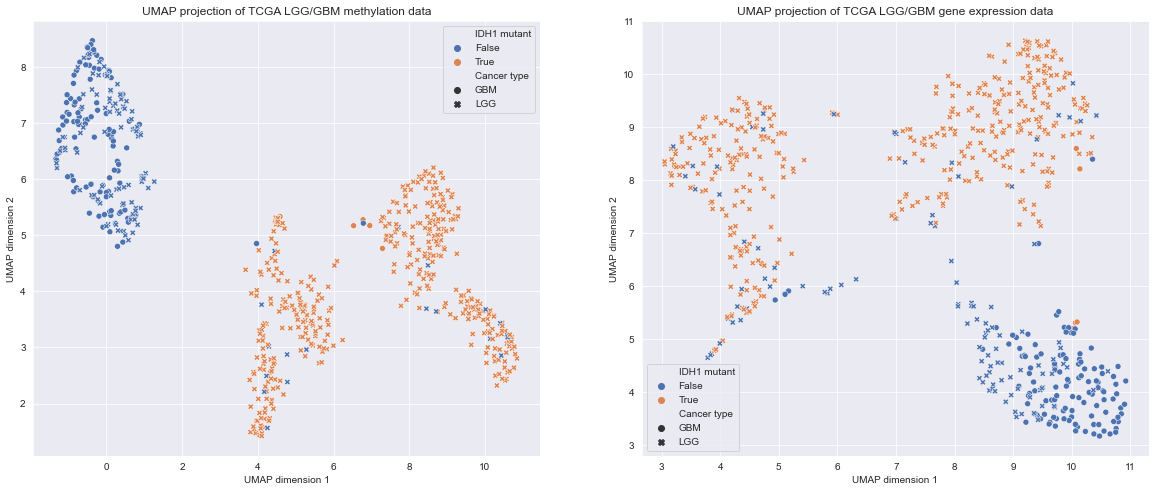

In [36]:
sns.set({'figure.figsize': (20, 8)})
fig, axarr = plt.subplots(1, 2)

sns.scatterplot(x='UMAP1', y='UMAP2', data=me_proj_df, hue='IDH1 mutant',
                style='Cancer type', ax=axarr[0])
axarr[0].set_xlabel('UMAP dimension 1')
axarr[0].set_ylabel('UMAP dimension 2')
axarr[0].set_title('UMAP projection of TCGA LGG/GBM methylation data')
axarr[0].legend()
sns.scatterplot(x='UMAP1', y='UMAP2', data=rnaseq_proj_df, hue='IDH1 mutant',
                style='Cancer type', ax=axarr[1])
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].set_title('UMAP projection of TCGA LGG/GBM gene expression data')
axarr[1].legend()